<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" align="left" /></a><br><br/>This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.

# ![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)

# Web Server Log Analysis with Apache Spark
This lab will demonstrate how easy it is to perform web server log analysis with Apache Spark.

Server log analysis is an ideal use case for Spark. It's a very large, common data source and contains a rich set of information. Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to perform data analysis on them. This homework will show you how to use Apache Spark on real-world text-based production logs and fully harness the power of that data. Log data comes from many sources, such as web, file, and compute servers, application logs, user-generated content, and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.

## How to complete this lab
This lab is broken up into sections with bite-sized examples for demonstrating Spark functionality for log processing.

It consists of 5 parts:
* Part 1: Introduction and Imports
* Part 2: Exploratory Data Analysis
* Part 3: Analysis Walk-Through on the Web Server Log File
* Part 4: Analyzing Web Server Log File
* Part 5: Exploring 404 Response Codes

## Part 1: Introduction and Imports
### A note about DataFrame column references
In Python, it's possible to access a DataFrame's columns either by attribute (`df.age`) or by indexing (`df['age']`). Referring to a column by attribute (`df.age`) is very Pandas-like, and it's highly convenient, especially when you're doing interactive data exploration. But it can fail, for reasons that aren't obvious. For example:

In [2]:
throwaway_df = sqlContext.createDataFrame([('Anthony', 10), ('Julia', 20), ('Fred', 5)], ('name', 'count'))
# throwaway_df.select(throwaway_df.count).show()

To understand why that failed, you have to understand how the attribute-column syntax is implemented.

When you type `throwaway_df.count`, Python looks for an existing attribute or method called `count` on the `throwaway_df` object. If it finds one, it uses it. Otherwise, it calls a special Python function (`__getattr__`), which defaults to throwing an exception. Spark has overridden `__getattr__` to look for a column on the DataFrame.

**This means you can only use the attribute (dot) syntax to refer to a column if the DataFrame does not already have an attribute with the column's name.**

In the above example, there's already a `count()` method on the `DataFrame` class, so `throwaway_df.count` does not refer to our "count" column; instead, it refers to the `count()` _method_.

To avoid this problem, you can refer to the column using subscript notation: `throwaway_df['count']`. This syntax will _always_ work.

In [3]:
throwaway_df.select(throwaway_df['count']).show()

+-----+
|count|
+-----+
|   10|
|   20|
|    5|
+-----+



### (1a) Library imports
We can import standard Python libraries ([modules](https://docs.python.org/2/tutorial/modules.html)) the usual way. An `import` statement will import the specified module. In this lab, we will provide any imports that are necessary.

Let's import some of the libraries we'll need:
* re: The regular expression library
* datetime: Date and time functions

In [4]:
import re
import datetime

#Quick test of regular expression library
m = re.search('(?<=abc)def', 'abcdef')
print(m.group(0))

#Quick test of the datetime library
print('This was last run on: {0}'.format(datetime.datetime.now()))

def
This was last run on: 2017-05-05 11:14:30.933140


### (1b) Getting help
Remember: There are some useful Python built-ins for getting help.

You can use Python's `dir()` function to get a list of all the attributes (including methods) accessible through the `sqlContext` object.

In [5]:
# List sqlContext's attributes
dir(sqlContext)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_inferSchema',
 '_instantiatedContext',
 '_jsc',
 '_jsqlContext',
 '_jvm',
 '_sc',
 '_ssql_ctx',
 'cacheTable',
 'clearCache',
 'createDataFrame',
 'createExternalTable',
 'dropTempTable',
 'getConf',
 'getOrCreate',
 'newSession',
 'range',
 'read',
 'readStream',
 'registerDataFrameAsTable',
 'registerFunction',
 'registerJavaFunction',
 'setConf',
 'sparkSession',
 'sql',
 'streams',
 'table',
 'tableNames',
 'tables',
 'udf',
 'uncacheTable']

Alternatively, you can use Python's `help()` function to get an easier to read list of all the attributes, including examples, that the sqlContext object has.

In [6]:
# Use help to obtain more detailed information
help(sqlContext)

Help on SQLContext in module pyspark.sql.context object:

class SQLContext(__builtin__.object)
 |  The entry point for working with structured data (rows and columns) in Spark, in Spark 1.x.
 |  
 |  As of Spark 2.0, this is replaced by :class:`SparkSession`. However, we are keeping the class
 |  here for backward compatibility.
 |  
 |  A SQLContext can be used create :class:`DataFrame`, register :class:`DataFrame` as
 |  tables, execute SQL over tables, cache tables, and read parquet files.
 |  
 |  :param sparkContext: The :class:`SparkContext` backing this SQLContext.
 |  :param sparkSession: The :class:`SparkSession` around which this SQLContext wraps.
 |  :param jsqlContext: An optional JVM Scala SQLContext. If set, we do not instantiate a new
 |      SQLContext in the JVM, instead we make all calls to this object.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sparkContext, sparkSession=None, jsqlContext=None)
 |      Creates a new SQLContext.
 |      
 |      >>> from d

In [8]:
# Help can be used on any Python object
help(map)

Help on built-in function map in module __builtin__:

map(...)
    map(function, sequence[, sequence, ...]) -> list
    
    Return a list of the results of applying the function to the items of
    the argument sequence(s).  If more than one sequence is given, the
    function is called with an argument list consisting of the corresponding
    item of each sequence, substituting None for missing values when not all
    sequences have the same length.  If the function is None, return a list of
    the items of the sequence (or a list of tuples if more than one sequence).



## Part 2: Exploratory Data Analysis
Let's begin looking at our data. For this lab, we will use a data set from NASA Kennedy Space Center web server in Florida. The full data set is freely available at http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html, and it contains all HTTP requests for two months. We are using a subset that only contains several days' worth of requests. The log file has already been downloaded for you.

In [20]:
import sys
import os
log_file_path = 'hdfs:/' + os.path.join('user', 'root', 'apache.access.log.PROJECT')

### (2a) Loading the log file
Now that we have the path to the file, let's load it into a DataFrame. We'll do this in steps. First, we'll use `sqlContext.read.text()` to read the text file. This will produce a DataFrame with a single string column called value.

In [21]:
base_df = sqlContext.read.text(log_file_path)
base_df.printSchema()

root
 |-- value: string (nullable = true)



Let's take a look at some of the data.

In [22]:
base_df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                          |
+-------------------------------------------------------------------------------------------------------------------------------+
|in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839     |
|uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0                                                        |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0                               |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0                             |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0"

In [23]:
base_df.count()

1043177

### (2b) Parsing the log file

If you're familiar with web servers at all, you'll recognize that this is in [Common Log Format](https://www.w3.org/Daemon/User/Config/Logging.html#common-logfile-format). The fields are:
    
    remotehost rfc931 authuser [date] "request" status bytes
    
field | meaning 
:---|:---
`remotehost` | Remote hostname (or IP number if DNS hostname is not available).
`rfc931` | The remote logname of the user. We don't really care about this field.
`authuser` | The username of the remote user, as authenticated by the HTTP server.
`[date]` | The date and time of the request.
`"request"`| The request, exactly as it came from the browser or client.
`status` | The HTTP status code the server sent back to the client.
`bytes` | The number of bytes (Content-Length) transferred to the client.

Next, we have to parse it into individual columns. We'll use the special built-in [regexp_extract()](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.regexp_extract) function to do the parsing. This function matches a column against a regular expression with one or more [capture groups](http://regexone.com/lesson/capturing_groups) and allows you to extract one of the matched groups. We'll use one regular expression for each field we wish to extract.

If you can't read these regular expressions, don't worry. Trust us: They work. If you find regular expressions confusing (and they certainly can be), and you want to learn more about them, start with the [RegexOne web site](http://regexone.com/). You might also find [Regular Expressions Cookbook](http://shop.oreilly.com/product/0636920023630.do), by Jan Goyvaerts and Steven Levithan, to be helpful.

Some people, when confronted with a problem, think "I know, I'll use regular expressions." Now they have two problems. (attributed to Jamie Zawinski)

In [24]:
from pyspark.sql.functions import split, regexp_extract
split_df = base_df.select(regexp_extract('value', r'^([^\s]+\s)', 1).alias('host'),
                          regexp_extract('value', r'^.*\[(\d\d/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]', 1).alias('timestamp'),
                          regexp_extract('value', r'^.*"\w+\s+([^\s]+)\s+HTTP.*"', 1).alias('path'),
                          regexp_extract('value', r'^.*"\s+([^\s]+)', 1).cast('integer').alias('status'),
                          regexp_extract('value', r'^.*\s+(\d+)$', 1).cast('integer').alias('content_size')).dropna(subset='status')
split_df.show(truncate=False)

+----------------------------+--------------------------+---------------------------------------------------+------+------------+
|host                        |timestamp                 |path                                               |status|content_size|
+----------------------------+--------------------------+---------------------------------------------------+------+------------+
|in24.inetnebr.com           |01/Aug/1995:00:00:01 -0400|/shuttle/missions/sts-68/news/sts-68-mcc-05.txt    |200   |1839        |
|uplherc.upl.com             |01/Aug/1995:00:00:07 -0400|/                                                  |304   |0           |
|uplherc.upl.com             |01/Aug/1995:00:00:08 -0400|/images/ksclogo-medium.gif                         |304   |0           |
|uplherc.upl.com             |01/Aug/1995:00:00:08 -0400|/images/MOSAIC-logosmall.gif                       |304   |0           |
|uplherc.upl.com             |01/Aug/1995:00:00:08 -0400|/images/USA-logosmall.gif        

### (2c) Data Cleaning
Let's see how well our parsing logic worked. First, let's verify that there are no null rows in the original data set.

In [25]:
base_df.filter(base_df['value'].isNull()).count()

0

If our parsing worked properly, we'll have no rows with null column values. Let's check.

In [26]:
bad_rows_df = split_df.filter(split_df['host'].isNull() |
                              split_df['timestamp'].isNull() |
                              split_df['path'].isNull() |
                              split_df['status'].isNull() |
                              split_df['content_size'].isNull()
                              )
bad_rows_df.count()

8756

Not good. We have some null values. Something went wrong. Which columns are affected?

(Note: This approach is adapted from an [excellent answer](http://stackoverflow.com/a/33901312) on StackOverflow.)

In [27]:
from pyspark.sql.functions import col, sum
def count_null(col_name):
    return sum(col(col_name).isNull().cast('integer')).alias(col_name)
exprs = [count_null(col_name) for col_name in split_df.columns]
split_df.agg(*exprs).show()

+----+---------+----+------+------------+
|host|timestamp|path|status|content_size|
+----+---------+----+------+------------+
|   0|        0|   0|     0|        8756|
+----+---------+----+------+------------+



Okay, they're all in the content_size column. Let's see if we can figure out what's wrong. Our original parsing regular expression for that column was:
```python
regexp_extract('value', r'^.*\s+(\d+)$', 1).cast('integer').alias('content_size')
```
The `\d+` selects one or more digits at the end of the input line. Is it possible there are lines without a valid content size? Or is there something wrong with our regular expression? Let's see if there are any lines that do not end with one or more digits.

**Note**: In the expression below, `~` means "not".

In [28]:
bad_content_size_df = base_df.filter(~ base_df['value'].rlike(r'\d+$'))
bad_content_size_df.count()

8756

That's it! The count matches the number of rows in `bad_rows_df` exactly.

Let's take a look at some of the bad column values. Since it's possible that the rows end in extra white space, we'll tack a marker character onto the end of each line, to make it easier to see trailing white space.

In [29]:
from pyspark.sql.functions import lit, concat
bad_content_size_df.select(concat(bad_content_size_df['value'], lit('*'))).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------+
|concat(value, *)                                                                                                            |
+----------------------------------------------------------------------------------------------------------------------------+
|gw1.att.com - - [01/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -*                            |
|js002.cc.utsunomiya-u.ac.jp - - [01/Aug/1995:00:07:33 -0400] "GET /shuttle/resources/orbiters/discovery.gif HTTP/1.0" 404 -*|
|tia1.eskimo.com - - [01/Aug/1995:00:28:41 -0400] "GET /pub/winvn/release.txt HTTP/1.0" 404 -*                               |
|itws.info.eng.niigata-u.ac.jp - - [01/Aug/1995:00:38:01 -0400] "GET /ksc.html/facts/about_ksc.html HTTP/1.0" 403 -*         |
|grimnet23.idirect.com - - [01/Aug/1995:00:50:12 -0400] "GET /www/software/winvn/winvn.html HTTP/1.0" 404 -*   

Ah. The bad rows correspond to error results, where no content was sent back and the server emitted a "`-`" for the `content_size` field. Since we don't want to discard those rows from our analysis, let's map them to 0.

### (2d) Fix the rows with null content_size
The easiest solution is to replace the null values in split_df with 0. The DataFrame API provides a set of functions and fields specifically designed for working with null values, among them:
* `fillna()`, which fills null values with specified non-null values.
* na, which returns a DataFrameNaFunctions object with many functions for operating on null columns.

We'll use `fillna()`, because it's simple. There are several ways to invoke this function. The easiest is just to replace all null columns with known values. But, for safety, it's better to pass a Python dictionary containing (column_name, value) mappings. That's what we'll do.

In [30]:
# Replace all null content_size values with 0.
cleaned_df = split_df.na.fill({'content_size': 0})
# Ensure that there are no nulls left.
exprs = [count_null(col_name) for col_name in cleaned_df.columns]
cleaned_df.agg(*exprs).show()

+----+---------+----+------+------------+
|host|timestamp|path|status|content_size|
+----+---------+----+------+------------+
|   0|        0|   0|     0|           0|
+----+---------+----+------+------------+



### (2e) Parsing the timestamp
Okay, now that we have a clean, parsed DataFrame, we have to parse the timestamp field into an actual timestamp. The Common Log Format time is somewhat non-standard. A User-Defined Function (UDF) is the most straightforward way to parse it.

In [31]:
from pyspark.sql.functions import udf

month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(s):
    return "{0:02d}-{1:02d}-{2:04d} {3:02d}:{4:02d}:{5:02d}".format(
        int(s[7:11]),
        month_map[s[3:6]],
        int(s[0:2]),
        int(s[12:14]),
        int(s[15:17]),
        int(s[18:20])
    )

u_parse_time = udf(parse_clf_time)
logs_df = cleaned_df.select('*', u_parse_time(split_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
total_log_entries = logs_df.count()

logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- path: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



Let's cache `logs_df`. We're going to be using it quite a bit from here forward.

In [33]:
logs_df.show(truncate=True)
print(total_log_entries)
logs_df.cache()

+--------------------+--------------------+------+------------+--------------------+
|                host|                path|status|content_size|                time|
+--------------------+--------------------+------+------------+--------------------+
|  in24.inetnebr.com |/shuttle/missions...|   200|        1839|1995-08-01 00:00:...|
|    uplherc.upl.com |                   /|   304|           0|1995-08-01 00:00:...|
|    uplherc.upl.com |/images/ksclogo-m...|   304|           0|1995-08-01 00:00:...|
|    uplherc.upl.com |/images/MOSAIC-lo...|   304|           0|1995-08-01 00:00:...|
|    uplherc.upl.com |/images/USA-logos...|   304|           0|1995-08-01 00:00:...|
|ix-esc-ca2-07.ix....|/images/launch-lo...|   200|        1713|1995-08-01 00:00:...|
|    uplherc.upl.com |/images/WORLD-log...|   304|           0|1995-08-01 00:00:...|
|slppp6.intermind....|/history/skylab/s...|   200|        1687|1995-08-01 00:00:...|
|piweba4y.prodigy....|/images/launchmed...|   200|       11853|19

DataFrame[host: string, path: string, status: int, content_size: int, time: timestamp]

## Part 3: Analysis Walk-Through on the Web Server Log File
Now that we have a DataFrame containing the parsed log file as a set of Row objects, we can perform various analyses.

### (3a) Example: Content Size Statistics
Let's compute some statistics about the sizes of content being returned by the web server. In particular, we'd like to know what are the average, minimum, and maximum content sizes.

We can compute the statistics by calling `.describe()` on the `content_size` column of `logs_df`. The `.describe()` function returns the count, mean, stddev, min, and max of a given column.

In [34]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.show()

+-------+------------------+
|summary|      content_size|
+-------+------------------+
|  count|           1043177|
|   mean|17531.555702435926|
| stddev|  68561.9990626412|
|    min|                 0|
|    max|           3421948|
+-------+------------------+



Alternatively, we can use SQL to directly calculate these statistics. You can explore the many useful functions within the `pyspark.sql.functions` module in the [documentation](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions).

After we apply the `.agg()` function, we call `.first()` to extract the first value, which is equivalent to `.take(1)[0]`.

In [35]:
from pyspark.sql import functions as sqlFunctions
content_size_stats = (logs_df
                      .agg(sqlFunctions.min(logs_df['content_size']),
                           sqlFunctions.avg(logs_df['content_size']),
                           sqlFunctions.max(logs_df['content_size']))
                      .first())

print('Using SQL Functions: ')
print('Content Size Avg: {1:,.2f}; Min: {0:,.2f}; Max: {2:,.0f}'.format(*content_size_stats))

Using SQL Functions: 
Content Size Avg: 17,531.56; Min: 0.00; Max: 3,421,948


### (3b) Example: HTTP Status Analysis
Next, let's look at the status values that appear in the log. We want to know which status values appear in the data and how many times. We again start with `logs_df`, then group by the `status` column, apply the `.count()` aggregation function, and sort by the `status` column.

In [37]:
status_to_count_df = (logs_df
                      .groupBy('status')
                      .count()
                      .sort('status')
                      .cache())
status_to_count_length = status_to_count_df.count()
print('Found %d response codes'%status_to_count_length)
status_to_count_df.show()
assert status_to_count_length == 7
assert status_to_count_df.take(100) == [(200, 940847), (302, 16244), (304, 79824), (403, 58), (404, 6185), (500, 2), (501, 17)]

Found 7 response codes
+------+------+
|status| count|
+------+------+
|   200|940847|
|   302| 16244|
|   304| 79824|
|   403|    58|
|   404|  6185|
|   500|     2|
|   501|    17|
+------+------+



### (3c) Example: Status Graphing
The `matplotlib` library can give us more control in our plot and is also useful outside the Databricks environment. In this case, we're essentially just reproducing the Databricks graph using matplotlib. However, `matplotlib` exposes far more controls than the Databricks graph, allowing you to change colors, label the axes, and more. We're using a set of helper functions from the `spark_notebook_helpers` library.

In [54]:
# np is just an alias for numpy.
# cm and plt are aliases for matplotlib.cm (for "color map") and matplotlib.pyplot, respectively.
# prepareSubplot is a helper.
from spark_notebook_helpers import prepareSubplot, np, plt, cm

We're using the "Set1" color map. See the list of Qualitative Color Maps at http://matplotlib.org/examples/color/colormaps_reference.html for more details. Feel free to change the color map to a different one, like "Accent".

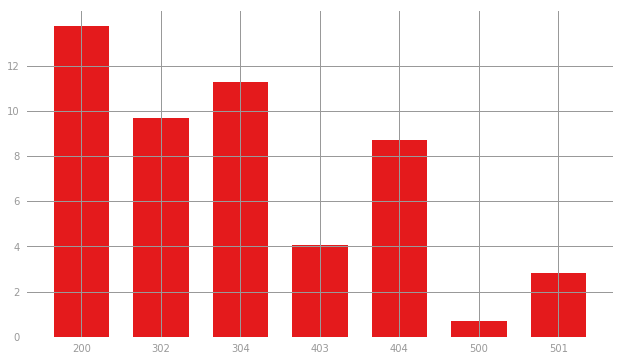

In [57]:
log_status_to_count_df = status_to_count_df.withColumn('log(count)', sqlFunctions.log(status_to_count_df['count']))
data = log_status_to_count_df.drop('count').collect()
x, y = zip(*data)
index = np.arange(len(x))
bar_width = 0.7
colorMap = 'Set1'
cmap = cm.get_cmap(colorMap)
fig, ax = prepareSubplot(np.arange(0, 6, 1), np.arange(0, 14, 2))
plt.bar(index, y, width=bar_width, color=cmap(0))
plt.xticks(index, x)
fig.show()

### (3d) Example: Frequent Hosts
Let's look at hosts that have accessed the server frequently (e.g., more than ten times). As with the response code analysis in (3b), we create a new DataFrame by grouping `successLogsDF` by the 'host' column and aggregating by count.

We then filter the result based on the count of accesses by each host being greater than ten. Then, we select the 'host' column and show 20 elements from the result.

In [58]:
# Any hosts that has accessed the server more than 10 times.
host_sum_df = (logs_df
               .groupBy('host')
               .count())
host_more_than_10_df = (host_sum_df
                        .filter(host_sum_df['count']>10)
                        .select(host_sum_df['host']))
host_more_than_10_df.show(truncate=False)

+-------------------------------+
|host                           |
+-------------------------------+
|prakinf2.prakinf.tu-ilmenau.de |
|alpha2.csd.uwm.edu             |
|cjc07992.slip.digex.net        |
|n1377004.ksc.nasa.gov          |
|163.205.2.134                  |
|huge.oso.chalmers.se           |
|163.205.44.27                  |
|shark.ksc.nasa.gov             |
|etc5.etechcorp.com             |
|dd07-029.compuserve.com        |
|131.182.101.161                |
|134.95.100.201                 |
|vab08.larc.nasa.gov            |
|ip11.iac.net                   |
|ad11-012.compuserve.com        |
|ad053.du.pipex.com             |
|204.184.6.19                   |
|p8.denver1.dialup.csn.net      |
|gate2.gdc.com                  |
|alcott.acsu.buffalo.edu        |
+-------------------------------+
only showing top 20 rows



### (3e) Example: Visualizing Paths
Now, let's visualize the number of hits to paths (URIs) in the log. To perform this task, we start with our `logs_df` and group by the `path` column, aggregate by `count`, and `sort` in descending order.

Next we visualize the results using `matplotlib`. We previously imported the `prepareSubplot` function and the `matplotlib.pyplo`t library, so we do not need to import them again. We extract the endpoints and the counts, and unpack the resulting list of `Rows` using a `map` function and `lambda` expression.

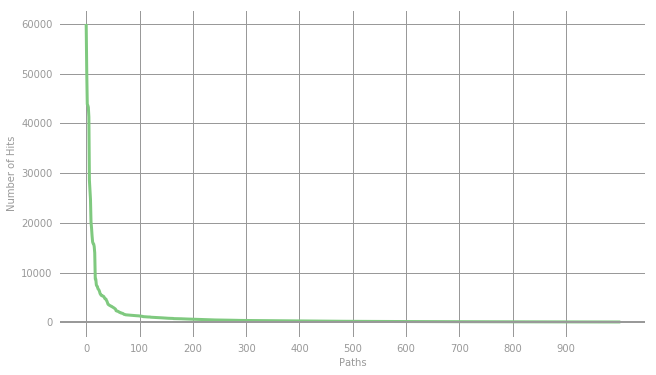

In [59]:
paths_df = (logs_df
            .groupBy('path')
            .count()
            .sort('count',ascending=False))
paths_counts = (paths_df
                .select('path', 'count')
                .rdd.map(lambda r:(r[0],r[1]))
                .collect())
paths, counts = zip(*paths_counts)

colorMap = 'Accent'
cmap = cm.get_cmap(colorMap)
index = np.arange(1000)

fig, ax = prepareSubplot(np.arange(0, 1000, 100), np.arange(0, 70000, 10000))
plt.xlabel('Paths')
plt.ylabel('Number of Hits')
plt.plot(index, counts[:1000], color=cmap(0), linewidth=3)
plt.axhline(linewidth=2, color='#999999')
fig.show()

In [62]:
paths_df.show(truncate=False)

+-----------------------------------------------+-----+
|path                                           |count|
+-----------------------------------------------+-----+
|/images/NASA-logosmall.gif                     |59666|
|/images/KSC-logosmall.gif                      |50420|
|/images/MOSAIC-logosmall.gif                   |43831|
|/images/USA-logosmall.gif                      |43604|
|/images/WORLD-logosmall.gif                    |43217|
|/images/ksclogo-medium.gif                     |41267|
|/ksc.html                                      |28536|
|/history/apollo/images/apollo-logo1.gif        |26766|
|/images/launch-logo.gif                        |24742|
|/                                              |20173|
|/images/ksclogosmall.gif                       |18955|
|/shuttle/missions/sts-69/mission-sts-69.html   |17383|
|/shuttle/missions/sts-69/sts-69-patch-small.gif|16155|
|/shuttle/missions/missions.html                |15819|
|/shuttle/countdown/                            

### (3f) Example: Top Paths
For the final example, we'll find the top paths (URIs) in the log. Because we sorted paths_df for plotting, all we need to do is call `.show()` and pass in `n=10` and `truncate=False` as the parameters to show the top ten paths without truncating.

In [64]:
print('Top Ten Paths:')
paths_df.show(truncate=False, n=10)

expected = [
  (u'/images/NASA-logosmall.gif', 59666),
  (u'/images/KSC-logosmall.gif', 50420),
  (u'/images/MOSAIC-logosmall.gif', 43831),
  (u'/images/USA-logosmall.gif', 43604),
  (u'/images/WORLD-logosmall.gif', 43217),
  (u'/images/ksclogo-medium.gif', 41267),
  (u'/ksc.html', 28536),
  (u'/history/apollo/images/apollo-logo1.gif', 26766),
  (u'/images/launch-logo.gif', 24742),
  (u'/', 20173)
]
assert paths_df.take(10) == expected, 'incorrect Top Ten Paths'

Top Ten Paths:
+---------------------------------------+-----+
|path                                   |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |59666|
|/images/KSC-logosmall.gif              |50420|
|/images/MOSAIC-logosmall.gif           |43831|
|/images/USA-logosmall.gif              |43604|
|/images/WORLD-logosmall.gif            |43217|
|/images/ksclogo-medium.gif             |41267|
|/ksc.html                              |28536|
|/history/apollo/images/apollo-logo1.gif|26766|
|/images/launch-logo.gif                |24742|
|/                                      |20173|
+---------------------------------------+-----+
only showing top 10 rows



## Part 4: Analyzing Web Server Log File
Now it is your turn to perform analyses on the web server log files.

### (4a) Exercise: Top Ten Error Endpoints
What are the top ten endpoints which did not have return code 200? Create a sorted list containing the endpoints and the number of times that they were accessed with a non-200 return code and show the top ten.

Think about the steps that you need to perform to determine which endpoints did not have a 200 return code, how you will uniquely count those endpoints and sort the list.

In [65]:
from pyspark.sql.functions import desc
not200DF = logs_df.filter(col('status')!=200)
not200DF.show(n=10)
logs_sum_df = (not200DF
               .groupBy('path')
               .count()
               .orderBy(col('count').desc()))
print('Top 10 failed URLs: ')
logs_sum_df.show(truncate=False, n=10)

+--------------------+--------------------+------+------------+--------------------+
|                host|                path|status|content_size|                time|
+--------------------+--------------------+------+------------+--------------------+
|    uplherc.upl.com |                   /|   304|           0|1995-08-01 00:00:...|
|    uplherc.upl.com |/images/ksclogo-m...|   304|           0|1995-08-01 00:00:...|
|    uplherc.upl.com |/images/MOSAIC-lo...|   304|           0|1995-08-01 00:00:...|
|    uplherc.upl.com |/images/USA-logos...|   304|           0|1995-08-01 00:00:...|
|    uplherc.upl.com |/images/WORLD-log...|   304|           0|1995-08-01 00:00:...|
|    uplherc.upl.com |/images/NASA-logo...|   304|           0|1995-08-01 00:00:...|
|kgtyk4.kj.yamagat...|/images/NASA-logo...|   304|           0|1995-08-01 00:00:...|
|kgtyk4.kj.yamagat...|/images/MOSAIC-lo...|   304|           0|1995-08-01 00:00:...|
|kgtyk4.kj.yamagat...|/images/USA-logos...|   304|           0|19

### (4b) Exercise: Number of Unique Hosts
How many unique hosts are there in the entire log?

There are multiple ways to find this. Try to find a more optimal way than grouping by 'host'.

In [66]:
from pyspark.sql.functions import countDistinct
unique_host_count = logs_df.agg(countDistinct(col('host'))).head()[0]
print('Unique hosts: {0}'.format(unique_host_count))

Unique hosts: 54507


### (4c) Exercise: Number of Unique Daily Hosts
For an advanced exercise, let's determine the number of unique hosts in the entire log on a day-by-day basis. This computation will give us counts of the number of unique daily hosts. We'd like a DataFrame sorted by increasing day of the month which includes the day of the month and the associated number of unique hosts for that day. Make sure you cache the resulting DataFrame `daily_hosts_df` so that we can reuse it in the next exercise.

Think about the steps that you need to perform to count the number of different hosts that make requests each day. _Since the log only covers a single month, you can ignore the month._ You may want to use the `dayofmonth` function in the `pyspark.sql.functions` module.

**Description of each variable**

    day_to_host_pair_df
    
A DataFrame with two columns

column | explanation
:---|:---
host	|the host name
day	|the day of the month

There will be one row in this DataFrame for each row in `logs_df`. Essentially, you're just trimming and transforming each row of `logs_df`. For example, for this row in `logs_df`:

    gw1.att.com - - [23/Aug/1995:00:03:53 -0400] "GET /shuttle/missions/sts-73/news HTTP/1.0" 302 -

your `day_to_host_pair_df` should have:

    gw1.att.com 23

#### something wrong

    day_group_hosts_df

This DataFrame has the same columns as `day_to_host_pair_df`, but with duplicate (`day`, `host`) rows removed.

    daily_hosts_df
    
A DataFrame with two columns:

column | explanation
:---|:---
day |	the day of the month
count |	the number of unique requesting hosts for that day

In [67]:
from pyspark.sql.functions import dayofmonth
day_to_host_pair_df = (logs_df
                       .select(col('host'), dayofmonth(col('time'))
                       .alias('day')))
day_group_hosts_df = day_to_host_pair_df.distinct()
daily_hosts_df = (day_group_hosts_df
                  .groupBy(col('day'))
                  .count()
                  .orderBy('day')
                 )
print('Unique hosts per day:')
daily_hosts_df.show(truncate=False, n=30)

Unique hosts per day:
+---+-----+
|day|count|
+---+-----+
|1  |2582 |
|3  |3222 |
|4  |4190 |
|5  |2502 |
|6  |2537 |
|7  |4106 |
|8  |4406 |
|9  |4317 |
|10 |4523 |
|11 |4346 |
|12 |2864 |
|13 |2650 |
|14 |4454 |
|15 |4214 |
|16 |4340 |
|17 |4385 |
|18 |4168 |
|19 |2550 |
|20 |2560 |
|21 |4134 |
|22 |4456 |
+---+-----+



### (4d) Exercise: Visualizing the Number of Unique Daily Hosts
Using the results from the previous exercise, we will use `matplotlib` to plot a line graph of the unique hosts requests by day. We need a list of days called `days_with_hosts` and a list of the number of unique hosts for each corresponding day called `hosts`.

**WARNING**: Simply calling `collect()` on your transformed DataFrame won't work, because `collect()` returns a list of Spark SQL `Row` objects. You must _extract_ the appropriate column values from the `Row` objects. Hint: A loop will help.

In [68]:
rows = daily_hosts_df.collect()
days_with_hosts = daily_hosts_df.rdd.map(lambda r: r[0]).collect()
hosts = daily_hosts_df.rdd.map(lambda r:r[1]).collect()
print(days_with_hosts)
print(hosts)

[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[2582, 3222, 4190, 2502, 2537, 4106, 4406, 4317, 4523, 4346, 2864, 2650, 4454, 4214, 4340, 4385, 4168, 2550, 2560, 4134, 4456]


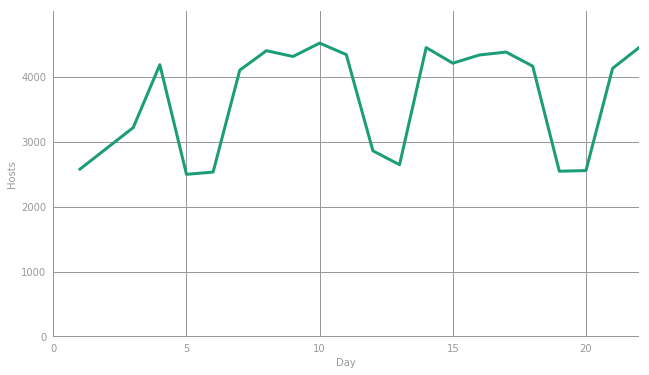

In [69]:
max_host = max(hosts)
max_day = max(days_with_hosts)

fig, ax = prepareSubplot(np.arange(0, 30, 5), np.arange(0, 5000, 1000))
colorMap = 'Dark2'
cmap = cm.get_cmap(colorMap)
plt.plot(days_with_hosts, hosts, color=cmap(0), linewidth=3)
plt.axis([0, max_day, 0, max_host+500])
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.axhline(linewidth=3, color='#999999')
plt.axvline(linewidth=2, color='#999999')
fig.show()

### (4e) Exercise: Average Number of Daily Requests per Host
Next, let's determine the average number of requests on a day-by-day basis. We'd like a list by increasing day of the month and the associated average number of requests per host for that day. Make sure you cache the resulting DataFrame `avg_daily_req_per_host_df` so that we can reuse it in the next exercise.

To compute the average number of requests per host, find the total number of requests per day (across all hosts) and divide that by the number of unique hosts per day (which we found in part 4c and cached as `daily_hosts_df`).

_Since the log only covers a single month, you can skip checking for the month._

In [71]:
total_req_per_day_df = (logs_df
                        .groupBy(dayofmonth(col('time')).alias('day'))
                        .count())
avg_daily_req_per_host_df = (total_req_per_day_df
                             .join(daily_hosts_df, daily_hosts_df['day']==total_req_per_day_df['day'],'outer')
                             .select(daily_hosts_df['day'],(total_req_per_day_df['count']/daily_hosts_df['count']).alias('avg_reqs_per_host_per_day')))
print('Average number of daily requests per Hosts is :')
avg_daily_req_per_host_df.sort('day').show(n=30)

Average number of daily requests per Hosts is :
+---+-------------------------+
|day|avg_reqs_per_host_per_day|
+---+-------------------------+
|  1|       13.166537567776917|
|  3|       12.845127250155183|
|  4|       14.213365155131266|
|  5|       12.745003996802557|
|  6|       12.777296018919984|
|  7|       13.968582562104238|
|  8|       13.650022696323196|
|  9|        14.00440120454019|
| 10|       13.540791510059695|
| 11|       14.091578462954441|
| 12|       13.292597765363128|
| 13|       13.766037735849057|
| 14|       13.442523574315222|
| 15|       13.964167062173706|
| 16|       13.053225806451612|
| 17|       13.450399087799315|
| 18|       13.494241842610364|
| 19|       12.585098039215687|
| 20|             12.876171875|
| 21|       13.434687953555878|
| 22|       12.961849192100539|
+---+-------------------------+



### (4f) Exercise: Visualizing the Average Daily Requests per Unique Host
Using the `result avg_daily_req_per_host_df` from the previous exercise, use matplotlib to plot a line graph of the average daily requests per unique host by day.

`days_with_avg` should be a list of days and `avgs` should be a list of average daily requests (as integers) per unique hosts for each corresponding day. Hint: You will need to extract these from the Dataframe in a similar way to part 4d.

In [97]:
days_with_avg = avg_daily_req_per_host_df.orderBy('day').rdd.map(lambda r:r[0]).collect()
avgs = avg_daily_req_per_host_df.orderBy('day').rdd.map(lambda r:r[1]).collect()
print(days_with_avg)
print(avgs)

[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[13.166537567776917, 12.845127250155183, 14.213365155131266, 12.745003996802557, 12.777296018919984, 13.968582562104238, 13.650022696323196, 14.00440120454019, 13.540791510059695, 14.091578462954441, 13.292597765363128, 13.766037735849057, 13.442523574315222, 13.964167062173706, 13.053225806451612, 13.450399087799315, 13.494241842610364, 12.585098039215687, 12.876171875, 13.434687953555878, 12.961849192100539]


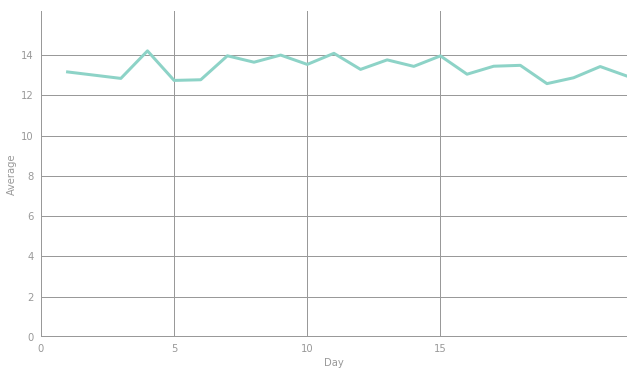

In [98]:
fig, ax = prepareSubplot(np.arange(0, 20, 5), np.arange(0, 16, 2))
colorMap = 'Set3'
cmap = cm.get_cmap(colorMap)
plt.plot(days_with_avg, avgs, color=cmap(0), linewidth=3)
plt.axis([0, max(days_with_avg), 0, max(avgs)+2])
plt.xlabel('Day')
plt.ylabel('Average')
plt.axhline(linewidth=3, color='#999999')
plt.axvline(linewidth=2, color='#999999')
fig.show()

## Part 5: Exploring 404 Status Codes
Let's drill down and explore the error 404 status records. We've all seen those "404 Not Found" web pages. 404 errors are returned when the server cannot find the resource (page or object) the browser or client requested.

### (5a) Exercise: Counting 404 Response Codes
Create a DataFrame containing only log records with a 404 status code. Make sure you `cache()` `not_found_df` as we will use it in the rest of this exercise.

How many 404 records are in the log?

In [99]:
not_found_df = logs_df.filter(col('status')==404).cache()
print('Found {0} 404 URLs'.format(not_found_df.count()))

Found 6185 404 URLs


### (5b) Exercise: Listing 404 Status Code Records
Using the DataFrame containing only log records with a 404 status code that you cached in part (5a), print out a list up to 40 _distinct_ paths that generate 404 errors.

**No path should appear more than once in your list.**

In [100]:
not_found_paths_df = not_found_df.select('path')
unique_not_found_paths_df  = not_found_paths_df.distinct()
print('404 URLs: ')
unique_not_found_paths_df.show(truncate=False, n=40)

404 URLs: 
+-------------------------------------------------+
|path                                             |
+-------------------------------------------------+
|/shuttle/missions/sts-68/images/images.html      |
|/history/apollo/a-001/news/                      |
|/history/apollo/a-003/movies/                    |
|/CSMT_PageNS                                     |
|/pub/wiinvn/win3/ww16_99_.zip                    |
|/public.win3/winvn                               |
|/shuttle/sts-1/sts-1-pa.jpg                      |
|/history/apollo/apollo/13                        |
|/shuttle/missions/sts-71/images/KSC-95EC-0916.txt|
|/history/apollo/-apollo-13/apollo-3.html         |
|/shuttle/technology/images/sts-comm-small.gif    |
|/shuttle/countdown/ac.html                       |
|/pub/winvn/docs                                  |
|/IMAGES/RSS.GIF                                  |
|/pub/winvn/readme.txt                            |
|/ksc.shtml                                       |
|

### (5c) Exercise: Listing the Top Twenty 404 Response Code paths
Using the DataFrame containing only log records with a 404 response code that you cached in part (5a), print out a list of the top twenty paths that generate the most 404 errors.

_Remember, top endpoints should be in sorted order_

In [101]:
top_20_not_found_df = (not_found_paths_df
                       .groupBy('path')
                       .count()
                       .orderBy(col('count').desc()))
print('Top 20 404 URLs:')
top_20_not_found_df.show(n=20, truncate=False)

Top 20 404 URLs:
+-----------------------------------------------------------------+-----+
|path                                                             |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |633  |
|/pub/winvn/release.txt                                           |494  |
|/shuttle/missions/STS-69/mission-STS-69.html                     |430  |
|/images/nasa-logo.gif                                            |319  |
|/elv/DELTA/uncons.htm                                            |178  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |154  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |146  |
|/images/crawlerway-logo.gif                                      |120  |
|/://spacelink.msfc.nasa.gov                                      |117  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|100  |
|/history/apollo/a-00

### (5d) Exercise: Listing the Top Twenty-five 404 Response Code Hosts
Instead of looking at the paths that generated 404 errors, let's look at the hosts that encountered 404 errors. Using the DataFrame containing only log records with a 404 status codes that you cached in part (5a), print out a list of the top twenty-five hosts that generate the most 404 errors.

In [102]:
hosts_404_count_df = (not_found_df
                      .groupBy('host')
                      .count()
                      .orderBy(col('count').desc()))
print('Top 25 hosts that generated errors')
hosts_404_count_df.show(n=25, truncate=False)

Top 25 hosts that generated errors
+-----------------------------+-----+
|host                         |count|
+-----------------------------+-----+
|piweba3y.prodigy.com         |39   |
|maz3.maz.net                 |39   |
|gate.barr.com                |38   |
|ts8-1.westwood.ts.ucla.edu   |37   |
|m38-370-9.mit.edu            |37   |
|nexus.mlckew.edu.au          |37   |
|204.62.245.32                |33   |
|163.206.104.34               |27   |
|spica.sci.isas.ac.jp         |27   |
|www-d4.proxy.aol.com         |26   |
|203.13.168.24                |25   |
|www-c4.proxy.aol.com         |25   |
|203.13.168.17                |25   |
|internet-gw.watson.ibm.com   |24   |
|scooter.pa-x.dec.com         |23   |
|crl5.crl.com                 |23   |
|piweba5y.prodigy.com         |23   |
|slip145-189.ut.nl.ibm.net    |22   |
|onramp2-9.onr.com            |22   |
|198.40.25.102.sap2.artic.edu |21   |
|msp1-16.nas.mr.net           |20   |
|gn2.getnet.com               |20   |
|dial055.mbnet.

### (5e) Exercise: Listing 404 Errors per Day
Let's explore the 404 records temporally. Break down the 404 requests by day (cache the errors_by_date_sorted_df DataFrame) and get the daily counts sorted by day in `errors_by_date_sorted_df`.

_Since the log only covers a single month, you can ignore the month in your checks._

In [105]:
errors_by_date_sorted_df = (not_found_df
                            .groupBy(dayofmonth('time').alias('day'))
                            .count()
                            .orderBy('day')
                            .cache())
print('404 errors by day:')
errors_by_date_sorted_df.show(n=30)

404 errors by day:
+---+-----+
|day|count|
+---+-----+
|  1|  243|
|  3|  303|
|  4|  346|
|  5|  234|
|  6|  372|
|  7|  532|
|  8|  381|
|  9|  279|
| 10|  314|
| 11|  263|
| 12|  195|
| 13|  216|
| 14|  287|
| 15|  326|
| 16|  258|
| 17|  269|
| 18|  255|
| 19|  207|
| 20|  312|
| 21|  305|
| 22|  288|
+---+-----+



### (5f) Exercise: Visualizing the 404 Errors by Day
Using the results from the previous exercise, use `matplotlib` to plot a line or bar graph of the 404 response codes by day.

**Hint**: You'll need to use the same technique you used in (4f).

In [106]:
days_with_errors_404 = errors_by_date_sorted_df.rdd.map(lambda r:r[0]).collect()
errors_404_by_day = errors_by_date_sorted_df.rdd.map(lambda r:r[1]).collect()
print(days_with_errors_404)
print(errors_404_by_day)

[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[243, 303, 346, 234, 372, 532, 381, 279, 314, 263, 195, 216, 287, 326, 258, 269, 255, 207, 312, 305, 288]


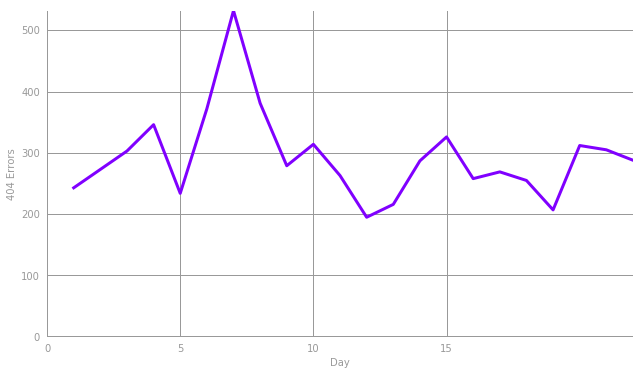

In [107]:
fig, ax = prepareSubplot(np.arange(0, 20, 5), np.arange(0, 600, 100))
colorMap = 'rainbow'
cmap = cm.get_cmap(colorMap)
plt.plot(days_with_errors_404, errors_404_by_day, color=cmap(0), linewidth=3)
plt.axis([0, max(days_with_errors_404), 0, max(errors_404_by_day)])
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.axhline(linewidth=3, color='#999999')
plt.axvline(linewidth=2, color='#999999')
fig.show()

### (5g) Exercise: Top Five Days for 404 Errors
Using the DataFrame `errors_by_date_sorted_df` you cached in the part (5e), what are the top five days for 404 errors and the corresponding counts of 404 errors?

In [108]:
top_err_date_df = errors_by_date_sorted_df.orderBy(col('count').desc())
print('Top five dates for 404 requests')
top_err_date_df.show(5)

Top five dates for 404 requests
+---+-----+
|day|count|
+---+-----+
|  7|  532|
|  8|  381|
|  6|  372|
|  4|  346|
| 15|  326|
+---+-----+
only showing top 5 rows



### (5h) Exercise: Hourly 404 Errors
Using the DataFrame `not_found_df` you cached in the part (5a) and sorting by hour of the day in increasing order, create a DataFrame containing the number of requests that had a 404 return code for each hour of the day (midnight starts at 0). Cache the resulting DataFrame `hour_records_sorted_df` and print that as a list.

In [109]:
from pyspark.sql.functions import hour
hour_records_sorted_df = (not_found_df
                          .groupBy(hour(col('time')).alias('hour'))
                          .count()
                          .orderBy('hour'))
print('Top hours for 404 requests')
hour_records_sorted_df.show(24)

Top hours for 404 requests
+----+-----+
|hour|count|
+----+-----+
|   0|  175|
|   1|  171|
|   2|  422|
|   3|  272|
|   4|  102|
|   5|   95|
|   6|   93|
|   7|  122|
|   8|  199|
|   9|  185|
|  10|  329|
|  11|  263|
|  12|  438|
|  13|  397|
|  14|  318|
|  15|  347|
|  16|  373|
|  17|  330|
|  18|  268|
|  19|  269|
|  20|  270|
|  21|  241|
|  22|  234|
|  23|  272|
+----+-----+



### (5i) Exercise: Visualizing the 404 Response Codes by Hour
Using the results from the previous exercise, use `matplotlib` to plot a line or bar graph of the 404 response codes by hour.

In [110]:
hours_with_not_found = hour_records_sorted_df.rdd.map(lambda r:r[0]).collect()
not_found_counts_per_hour = hour_records_sorted_df.rdd.map(lambda r:r[1]).collect()
print(hours_with_not_found)
print(not_found_counts_per_hour)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[175, 171, 422, 272, 102, 95, 93, 122, 199, 185, 329, 263, 438, 397, 318, 347, 373, 330, 268, 269, 270, 241, 234, 272]


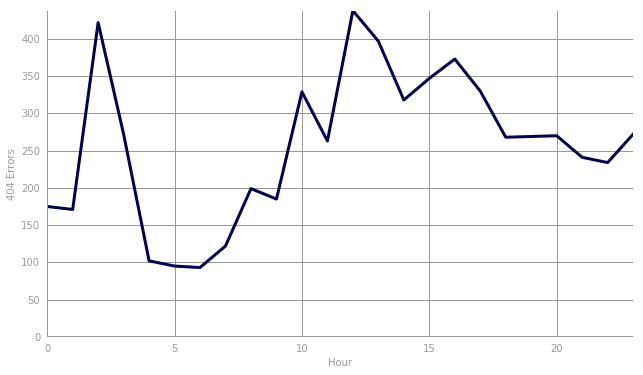

In [111]:
fig, ax = prepareSubplot(np.arange(0, 25, 5), np.arange(0, 500, 50))
colorMap = 'seismic'
cmap = cm.get_cmap(colorMap)
plt.plot(hours_with_not_found, not_found_counts_per_hour, color=cmap(0), linewidth=3)
plt.axis([0, max(hours_with_not_found), 0, max(not_found_counts_per_hour)])
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.axhline(linewidth=3, color='#999999')
plt.axvline(linewidth=2, color='#999999')
fig.show()